In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pp

import requests
import json
from difflib import get_close_matches
from difflib import SequenceMatcher

from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial.distance import cosine

plt.style.use('seaborn')

In [2]:
genres_item_matrix = pd.read_csv('data/genres_item_matrix.csv', index_col='id')
tag_item_matrix = pd.read_csv('data/tag_item_matrix.csv', index_col='id')
tag_rank_item_matrix = pd.read_csv('data/tag_rank_item_matrix.csv', index_col='id')
title_df = pd.read_csv('data/title_df.csv', index_col='id')
adjusted_score_df = pd.read_csv('data/adjusted_score_df.csv', index_col='id')

In [3]:
binary_df = pd.concat([genres_item_matrix, tag_item_matrix], axis=1)
binary_df.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99726,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98526,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
rank_df = pd.concat([genres_item_matrix, tag_rank_item_matrix], axis=1)
rank_df.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [5]:
sim_mat = cosine_similarity(rank_df.values)

In [6]:
x = ((adjusted_score_df['adjusted_score']))
# x /= max(x)
x

id
10161     0.650287
99726     0.692942
98526     0.522631
966       0.658964
4876      0.549320
            ...   
99586     0.590663
99916     0.688089
101283    0.612901
101633    0.668539
101089    0.000000
Name: adjusted_score, Length: 9832, dtype: float64

In [7]:
adjusted_scores = round(x, 4)
adjusted_scores

id
10161     0.6503
99726     0.6929
98526     0.5226
966       0.6590
4876      0.5493
           ...  
99586     0.5907
99916     0.6881
101283    0.6129
101633    0.6685
101089    0.0000
Name: adjusted_score, Length: 9832, dtype: float64

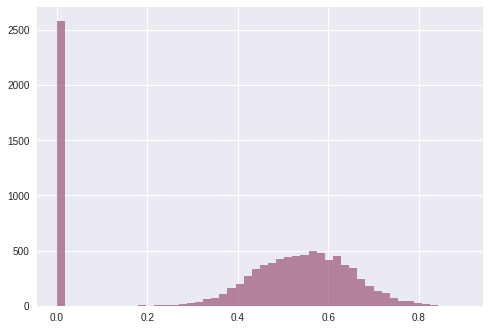

In [8]:
plt.hist(adjusted_score_df['adjusted_score'], bins=50, alpha=.5)
plt.hist(adjusted_scores, bins=50, alpha=.25, color='red');

In [9]:
weighted_sim_mat = (sim_mat * adjusted_scores.to_numpy())
weighted_sim_mat

array([[0.6503    , 0.        , 0.26338692, ..., 0.        , 0.10123952,
        0.        ],
       [0.        , 0.6929    , 0.        , ..., 0.03612725, 0.15541311,
        0.        ],
       [0.32774687, 0.        , 0.5226    , ..., 0.        , 0.14556139,
        0.        ],
       ...,
       [0.        , 0.04084283, 0.        , ..., 0.6129    , 0.        ,
        0.        ],
       [0.09848326, 0.16108563, 0.11379264, ..., 0.        , 0.6685    ,
        0.        ],
       [0.        , 0.24852701, 0.        , ..., 0.02704619, 0.23269597,
        0.        ]])

In [10]:
def get_anime_id(_user_preferred_title):
    id_list = []
    anime_id = title_df[title_df['userPreferred'].isin([_user_preferred_title])].index
    id_list.append(anime_id)
    
    return id_list[0].values[0]


def get_top_n_recommendations(anime_id, dataframe, similarity_matrix, n=5):
    positional_idx = dataframe.index.get_loc(anime_id)
    
    top_n = np.argsort(similarity_matrix[positional_idx,:])[-n-1:-1]
    recom_titles = []
    for idx, row in title_df.iloc[top_n,:].iterrows():
        if type(row['english']) != float:
            recom_titles.append(row['english'])
        else:
            recom_titles.append(row['userPreferred'])
    
    return recom_titles


        
def get_title_from_id(_id):
    '''Searches the title dataframe based on an anime id and tries to return the english title. 
    If an english title is not available, the "user preferred" is give. '''
    title = None
    if pd.isna(title_df.loc[title_df.index == _id, 'english']).values[0]:
        title = title_df.loc[title_df.index == _id, 'userPreferred'].values[0]
    else:
        title = title_df.loc[title_df.index == _id, 'english'].values[0]
    
    return title


def get_user_preferred(initial_search):
    '''Search the AniList API for a show based on a query.
    
    Returns the user preferred title 
    '''
    query = '''
    query ($search: String) {
      Media (type: ANIME, search: $search) {
        id
        title {
          romaji
          english
          native
          userPreferred
        }
      }
    }
    '''
    variables = {'search': initial_search}

    url = 'https://graphql.anilist.co'
    response = requests.post(url, 
                             json={'query': query, 
                                   'variables': variables})
    user_preferred_title = response.json()['data']['Media']['title']['userPreferred']

    return user_preferred_title


def view_features(search_term, df):
    _id = title_df[title_df['userPreferred'] == search_term].index
    _df = df.loc[_id,:]

    return list(_df.loc[:, (_df != 0).any(axis=0)].columns)



def view_features_from_id(_id, _df):
    single_show = _df.loc[_id,:]
    
    return set(single_show[single_show != 0].index)



def get_common_tags(list_of_ids):
    list_of_tags = [view_features_from_id(_id, binary_df) for _id in list_of_ids]

    return set.intersection(*list_of_tags)

In [11]:
def get_recommendations(search_term, similarity_matrix=weighted_sim_mat):
    user_preferred_title = get_user_preferred(search_term)
    _id = get_anime_id(user_preferred_title)
    print('Getting recommendations for: ', get_title_from_id(_id))
    rec_list = get_top_n_recommendations(_id, 
                                         rank_df, 
                                         similarity_matrix, 
                                         n=5)
    return rec_list



In [71]:
get_top_n_recommendations(get_anime_id(get_user_preferred("Wolf's Rain")), rank_df, weighted_sim_mat, n=5)

['Tsubasa: Spring Thunder Chronicles',
 'Attack on Titan Season 2',
 'Nausicaä of the Valley of the Wind',
 "Wolf's Rain OVA",
 'Made in Abyss']

In [66]:
get_top_n_recommendations(get_anime_id(get_user_preferred("Wolf's Rain")), rank_df, sim_mat, n=5)

['Wan Wan Chuushingura',
 "Wolf's Rain OVA",
 'Galilei Donna',
 'Jyu-Oh-Sei: Planet of the Beast King',
 'Final Fantasy VII: Last Order']

In [13]:
# list of titles to list of ids
title_list = ["Wolf's Rain", "Ergo Proxy", "Texhnolyze"]
id_list = []
for title in title_list:
    user_preferred_title = get_user_preferred(title)
    id_list.append(get_anime_id(user_preferred_title))
    print(user_preferred_title)

Wolf's Rain
Ergo Proxy
Texhnolyze


In [14]:
rank_df.loc[id_list,:]

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
202,1,1,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
790,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# get the mean vector for a list of anime
mean_vector = rank_df.loc[id_list,:].mean(axis=0)
mean_vector

action       0.666667
adventure    0.333333
comedy       0.000000
drama        0.666667
ecchi        0.000000
               ...   
yakuza       0.000000
yandere      0.000000
youkai       0.000000
yuri         0.000000
zombie       0.000000
Length: 265, dtype: float64

In [23]:
sim_mat = cosine_similarity(rank_df.append(mean_vector, ignore_index=True).values)
sim_mat

array([[1.        , 0.        , 0.50399334, ..., 0.15144281, 0.        ,
        0.56113635],
       [0.        , 1.        , 0.        , ..., 0.23248034, 0.35867658,
        0.17719574],
       [0.50399334, 0.        , 1.        , ..., 0.21774329, 0.        ,
        0.35416838],
       ...,
       [0.15144281, 0.23248034, 0.21774329, ..., 1.        , 0.34808671,
        0.09476629],
       [0.        , 0.35867658, 0.        , ..., 0.34808671, 1.        ,
        0.01915827],
       [0.56113635, 0.17719574, 0.35416838, ..., 0.09476629, 0.01915827,
        1.        ]])

In [28]:
np.append(adjusted_scores.to_numpy(), 0)

array([0.6503, 0.6929, 0.5226, ..., 0.6685, 0.    , 0.    ])

In [30]:
sims = sim_mat[-1:] * np.append(adjusted_scores.to_numpy(), 0)
sims

array([[0.36490697, 0.12277893, 0.1850884 , ..., 0.06335127, 0.        ,
        0.        ]])

In [52]:
for pos in sims.argsort()[0][:20:-1]:
    for title in title_df.iloc[pos,[1, 3]]:
        print(title)
    print('-----')

Texhnolyze
Texhnolyze
-----
Ergo Proxy
Ergo Proxy
-----
Neon Genesis Evangelion
Shin Seiki Evangelion
-----
Wolf's Rain
Wolf's Rain
-----
nan
Casshern Sins
-----
Land of the Lustrous
Houseki no Kuni
-----
Neon Genesis Evangelion: The End of Evangelion
Shin Seiki Evangelion Movie: THE END OF EVANGELION
-----
Cowboy Bebop: The Movie - Knockin' on Heaven's Door
Cowboy Bebop: Tengoku no Tobira
-----
nan
Wolf's Rain OVA
-----
Ghost in the Shell: Stand Alone Complex 2nd GIG
Koukaku Kidoutai: Stand Alone Complex 2nd GIG
-----
PSYCHO-PASS
PSYCHO-PASS
-----
Ghost in the Shell
Koukaku Kidoutai
-----
Akira
Akira
-----
Made in Abyss
Made in Abyss
-----
Cowboy Bebop
Cowboy Bebop
-----
Ghost in the Shell: Stand Alone Complex - The Laughing Man
Koukaku Kidoutai: Stand Alone Complex - The Laughing Man
-----
Serial Experiments Lain
Serial Experiments Lain
-----
Attack on Titan
Shingeki no Kyojin
-----
nan
Mardock Scramble: The Third Exhaust
-----
Attack on Titan Season 2
Shingeki no Kyojin 2
-----
Naus

Saint Seiya: The Hades Chapter - Inferno
Saint Seiya: Meiou Hades Meikai-hen
-----
Berserk: The Golden Age Arc III - The Advent
Berserk: Ougon Jidaihen III - Kourin
-----
nan
Viper's Creed
-----
nan
Madlax
-----
nan
DRAMAtical Murder OVA: Data_xx_Transitory
-----
nan
Maetel Legend
-----
Fist of the North Star Movie
Hokuto no Ken Movie
-----
Revolutionary Girl Utena
Shoujo Kakumei Utena
-----
the Garden of sinners Chapter 3: ever cry, never life. (Remaining Sense of Pain)
Kara no Kyoukai: Tsuukaku Zanryuu
-----
Carole & Tuesday
Carole & Tuesday
-----
Urusei Yatsura Movie 3: Remember My Love
Urusei Yatsura Movie 3: Remember My Love
-----
Astro Boy (1980)
Tetsuwan Atom (1980)
-----
Planetes
Planetes
-----
Sgt. Frog Movie 2
Keroro Gunsou Movie 2: Shinkai no Princess de Arimasu!
-----
Baldr Force EXE
Baldr Force Exe Resolution
-----
Zeorymer - Project Hades
Mei Ou Project Zeorymer
-----
nan
Shin Hakkenden
-----
nan
xxxHOLiC Shunmuki
-----
nan
Kidou Senshi Gundam AGE: Memory of Eden
-----
Pa

-----
nan
Uchuu no Kishi Tekkaman Blade II
-----
Armored Trooper Votoms: Votoms Finder
Votoms Finder
-----
nan
Soreyuke! Uchuu Senkan Yamamoto Yohko (1999)
-----
Black Magic M-66
Black Magic M-66
-----
the Garden of sinners Chapter 4: garan-no-dou. (The Hollow Shrine)
Kara no Kyoukai: Garan no Dou
-----
Snow White with the Red Hair: Nandemonai Takaramono, Kono Page
Akagami no Shirayuki-hime: Nandemonai Takaramono, Kono Page
-----
Lupin III: Crisis in Tokyo
Lupin III: Honoo no Kioku - Tokyo Crisis
-----
nan
Cluster Edge
-----
Star Fox Zero: The Battle Begins
Star Fox Zero: The Battle Begins
-----
Digimon Adventure tri. Chapter 2: Determination
Digimon Adventure tri. 2: Ketsui
-----
nan
Togainu no Chi
-----
Digimon Adventure tri. Chapter 1: Reunion
Digimon Adventure tri. 1: Saikai
-----
Delinquent Detective
Sukeban Deka
-----
Birdy the Mighty Decode:02
Tetsuwan Birdy Decode:02
-----
nan
Mushrambo (2008)
-----
nan
Zenonzard THE ANIMATION
-----
nan
Macross Frontier Deculture Edition
-----


Full Metal Panic! Invisible Victory
Full Metal Panic! Invisible Victory
-----
Riddle Story of Devil
Akuma no Riddle
-----
nan
Shion no Ou
-----
Symphogear
Senki Zesshou Symphogear
-----
Ushio and Tora
Ushio to Tora
-----
nan
Galerians: Rion
-----
nan
Ajin: Shoutotsu
-----
The Future Diary: Ura Mirai Nikki
Mirai Nikki (TV): Ura Mirai Nikki
-----
Dragon Ball Z: Fusion Reborn
Dragon Ball Z Movie: Fukkatsu no Fusion!! Goku to Vegeta
-----
nan
Utopa
-----
nan
Soliton no Akuma
-----
Super Dimensional Cavalry Southern Cross
Choujikuu Kidan Southern Cross
-----
Project A-ko
Project A-Ko
-----
Starship Troopers: Traitor of Mars
Starship Troopers: Kasei no Uragirisha
-----
Blood Blockade Battlefront & Beyond OVA
Kekkai Sensen & BEYOND OVA
-----
nan
Zero no Tsukaima: Princesses no Rondo Picture Drama
-----
Haikyu!! The Movie: Battle of Concepts
Haikyuu!! Concept no Tatakai
-----
Red Hawk - Weapon Of Death
Bulg-eunmae
-----
Armor Hunter Mellowlink
Kikou Ryouhei Mellowlink
-----
nan
Yamiyo
-----
Fi

Gunparade March
Gunparade March: Arata Naru Kougunka
-----
Rage of Bahamut: Genesis - Short Story
Shingeki no Bahamut: GENESIS - Short Story
-----
selector spread WIXOSS
selector spread WIXOSS
-----
Case Closed Movie 01: The Time Bombed Skyscraper
Meitantei Conan: Tokei Jikake no Matenrou
-----
Violence Jack: Slumking
Violence Jack: Harem Bomber
-----
nan
Trigun: Badlands Rumble
-----
nan
Gallery Fake
-----
nan
Galaxy Angel 3 Specials
-----
Beast King GoLion
Hyakujuu-Ou GoLion
-----
nan
Shadow Skill: Eigi
-----
Street Fighter II: The Animated Movie
Street Fighter II: The Movie
-----
Norn9
NORN9: Norn + Nonet
-----
nan
Love Position, Legend of the Halley
-----
Kiki's Delivery Service
Majo no Takkyuubin
-----
nan
Rec
-----
Cosmic Fantasy
Cosmic Fantasy: Ginga Mehyou no Wana
-----
Altair: A Record of Battles
Shoukoku no Altair
-----
Persona 3 the Movie: #2 Midsummer Knight's Dream
Persona 3 the Movie 2: Midsummer Knight's Dream
-----
Pokémon: Jirachi Wish Maker
Pocket Monsters Advanced Ge

nan
Garo: Divine Flame
-----
InuYasha the Movie 2: The Castle Beyond the Looking Glass
InuYasha: Kagami no Naka no Mugenjo
-----
The Jungle Book
Jungle Book Shounen Mowgli
-----
Queen's Blade: Inheritor of the Throne
Queen's Blade: Gyokuza wo Tsugu Mono
-----
Monkey Typhoon
Asobot Senki Gokuu
-----
nan
Bokura no Nanokakan Sensou
-----
Snow White with the Red Hair
Akagami no Shirayuki-hime
-----
Super Heavy God Gravion Zwei
Choujuushin Gravion Zwei
-----
All Purpose Cultural Cat Girl Nuku Nuku Dash!
Bannou Bunka Neko-Musume DASH!
-----
Sgt. Frog
Keroro Gunsou
-----
Monster Rancher
Monster Farm: Enbanseki no Himitsu
-----
nan
Gundress
-----
Beyond the Boundary -I'LL BE HERE-: Past
Kyoukai no Kanata Movie: I'LL BE HERE - Kako-hen
-----
nan
Divergence Eve
-----
Bleach the Movie 3: Fade to Black
Bleach: Fade to Black - Kimi no Na wo Yobu
-----
InuYasha the Movie 3: Swords of an Honorable Ruler
InuYasha: Tenka Hadou no Ken
-----
nan
Kiss Dum: Engage Planet
-----
nan
King of Fighters: Another

nan
Tekkon Kinkreet Pilot
-----
Eagle Riders (2)
Kagaku Ninja-Tai Gatchaman F
-----
nan
Tiger & Bunny: Too many cooks spoil the broth.
-----
Crazy little Thing
Yodomi no Sakagi
-----
Robot Town Sagami 2028
Robot Town Sagami 2028
-----
Natsume Yujin-cho 5 Specials
Natsume Yuujinchou Go Specials
-----
Fox Fears
Kitsune Tsuki
-----
nan
Shashinkan
-----
nan
Nineteen 19
-----
Code Geass: Oz the Reflection Picture Drama
Code Geass: Soubou no Oz Picture Drama
-----
Regalia: The Three Sacred Stars
Regalia: The Three Sacred Stars
-----
Catblue Dynamite
Catblue: Dynamite
-----
Naruto the Movie: Guardians of the Crescent Moon Kingdom
Naruto the Movie: Dai Koufun! Mikazuki Jima no Animaru Panikku Dattebayo!
-----
Gauche the Cellist
Cello Hiki no Gauche
-----
Food Wars! Shokugeki no Soma
Shokugeki no Souma
-----
nan
Angel Beats!: Another Epilogue
-----
Juden Chan
Fight Ippatsu! Juuden-Chan!!
-----
UFO Ultramaiden Valkyrie
UFO Princess Valkyrie
-----
Sea Prince and the Fire Child
Sirius no Densetsu


Code Geass: Akito the Exiled - The Wyvern Divided
Code Geass: Boukoku no Akito 2 - Hikisakareshi Yokuryuu
-----
nan
663114
-----
Dragon Ball GT: A Hero's Legacy
Dragon Ball GT: Goku Gaiden! Yuuki no Akashi wa Suushinchuu
-----
nan
Punch Line
-----
nan
Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi
-----
Luck & Logic
Luck & Logic
-----
Mobile Suit Gundam MS IGLOO: The Hidden One Year War
Kidou Senshi Gundam MS IGLOO: Ichinen Sensou Hiwa
-----
Maison Ikkoku: Prelude
Maison Ikkoku: Prelude - Meguru Haru no Sakura no you ni...
-----
KONOSUBA -God's blessing on this wonderful world! 2
Kono Subarashii Sekai ni Shukufuku wo! 2
-----
Uchuu Senkan Tiramisu Specials
Uchuu Senkan Tiramisu Specials
-----
3x3 Eyes
3x3 Eyes
-----
Taisei Corporation CM: Sri Lanka Expressway
Taisei Kensetsu: Sri Lanka Kousokudouro
-----
nan
Katte ni Kaizou
-----
Legend of Crystania: The Motion Picture
Hajimari no Boukensha-tachi: Legend of Crystania
-----
Aoharu x Machinegun: Kemono-tachi no Senjou da na!
Aoh

Day Break Illusion
Genei wo Kakeru Taiyou
-----
Spring Song
Haru no Uta
-----
Arakawa Under the Bridge
Arakawa Under the Bridge
-----
The Great Rabbit
Great Rabbit
-----
Kagewani ~II~
KAGEWANI: Shou
-----
Slayers: The Motion Picture
Slayers Movie
-----
nan
Battle Spirits: Brave
-----
nan
Eikoku Koi Monogatari Emma: Intermission
-----
Pokémon: The Rise of Darkrai
Pocket Monsters Diamond & Pearl: Dialga vs. Palkia vs. Darkrai
-----
nan
Slayers Great
-----
nan
Slayers Return
-----
ReLIFE OVA
ReLIFE Kanketsu-hen
-----
nan
Memories Off 2nd
-----
nan
Winter Sonata Episode 0
-----
The Story of a Family
Kazoku no Hanashi
-----
There Goes Tomoe!
Tomoe ga Yuku!
-----
Assassination Classroom
Ansatsu Kyoushitsu
-----
D.N.Angel
D.N.Angel
-----
Legend of the Millennium Dragon
Onigamiden
-----
nan
Eyeshield 21
-----
nan
Kagewani
-----
nan
Marmalade Boy Movie
-----
nan
Major S4
-----
nan
Danball Senki W
-----
nan
Hanada Shounen-shi
-----
Lostorage conflated WIXOSS
Lostorage conflated WIXOSS
-----
nan


Girl from Phantasia
Fantasia
-----
nan
Slayers Excellent
-----
Amagi Brilliant Park
Amagi Brilliant Park
-----
nan
Dream Hunter REM
-----
Generation of Chaos III: Time of the Seal
Generation of Chaos III: Toki no Fuuin
-----
Detective Opera Milky Holmes: Alternative
Tantei Opera Milky Holmes: Alternative
-----
Time of Shura
Mutsu Enmei Ryuu Gaiden: Shura no Toki
-----
nan
Ai Shoujo Pollyanna Monogatari
-----
Gonna be the Twin-Tails!!
Ore, Twintail ni Narimasu.
-----
Ogre Slayer
Onikirimaru
-----
Grand Prix
Arrow Emblem Grand Prix no Taka
-----
nan
Youchien Senshi: Hanamaru Girls
-----
Ninja Fireball in Edo
Ninjutsu Hinotama Kozou: Edo no Maki
-----
nan
Soul Reviver
-----
Pokémon: Pikachu's Winter Vacation
Pikachu no Fuyuyasumi
-----
nan
Freezing Vibration Specials
-----
nan
High School DxD
-----
nan
Bronze: Zetsuai Since 1989
-----
Broken Blade 5
Break Blade 5: Shisen no Hate
-----
nan
Ten no Kawa
-----
nan
To Heart
-----
ONE PIECE Mega Mecha Soldier of Karakuri Castle
One Piece THE MO

nan
Megami Tengoku
-----
Genesis Climber Mospeada: Love
Genesis Climber Mospeada: Love, Live, Alive
-----
The Trapp Family Story
Trapp Ikka Monogatari
-----
Lupin III: Dead or Alive
Lupin III: Dead or Alive
-----
Venus Project -Climax-
VENUS PROJECT: CLIMAX
-----
Kämpfer
Kämpfer
-----
Butt Attack Punisher Girl Gautaman R
Dengeki Oshioki Musume Gootaman R: Ai to Kanashimi no Final Battle
-----
nan
Nezumi Monogatari: George to Gerald no Bouken
-----
Laid-Back Camp
Yuru Camp△
-----
Sister Princess
Sister Princess
-----
The Wild Swans
Sekai Meisaku Douwa: Hakuchou no Ouji
-----
Dorami & Doraemons: Space Land's Critical Event!
Dorami & Doraemons: Space Land Kiki Ippatsu!
-----
Tales of Byston Well: Garzey's Wing
Byston Well Monogatari: Garzey no Tsubasa
-----
nan
Kawa no Hikari
-----
nan
Takahashi Rumiko Anthology
-----
nan
Nurarihyon no Mago: Jump Super Anime Tour Special
-----
The Great Adventures of Robin Hood
Robin Hood no Daibouken
-----
I'm In Love With My Sister
Boku wa Imouto ni Koi

Bottle Fairy
Binzume Yousei
-----
The SoulTaker
The SoulTaker: Tamashiigari
-----
Fullmetal Alchemist: Premium OVA Collection
Hagane no Renkinjitsushi: Premium Collection
-----
Sword for Truth
Shuranosuke Zanmaken: Shikamamon no Otoko
-----
Dog Days'': Gravure Talk
Dog Days'': Gravure Talk
-----
nan
Ojamajo Doremi Na-i-sho
-----
Gintama: Love Incense Arc
Gintamaº: Aizome Kaori-hen
-----
Water Spider Monmon
Mizugumo Monmon
-----
nan
Mahou Tsukai Jiji
-----
Dr. Slump & Arale-chan The Secret of Nanaba Castle
Dr. Slump Arale-chan Hoyoyo! Nanaba Shiro no Hihou
-----
nan
Bakusou Kyoudai Let's & Go WGP
-----
Prince of Tennis: A Day of the Survival Mountain
Tennis no Ouji-sama: Sonzoku Yama no Hi
-----
nan
Dragon Collection
-----
Bunny Drop
Usagi Drop
-----
Princess Jellyfish: Go
Kuragehime: Soreike! Amars Tankentai
-----
nan
Grander Musashi RV
-----
Barbapapa
Barbapapa
-----
Miss Bernard said.
Bernard-jou Iwaku.
-----
Genshiken
Genshiken
-----
Summer Storm! Open for Business
Natsu no Arashi! 

Love Hina
Love Hina
-----
nan
Gokicha!! Cockroach Girl!
-----
nan
Blade & Soul Specials
-----
Momokuri
Momokuri
-----
Kumamiko -Girl Meets Bear
Kuma Miko
-----
UzaMaid!
Uchi no Maid ga Uzasugiru
-----
nan
Chuu Bra!!
-----
Hitoribocchi no Marumaruseikatsu
Hitoribocchi no Marumaru Seikatsu
-----
nan
Chibi Maruko-chan: Watashi no Suki na Uta
-----
Strawberry 100%
Ichigo 100%
-----
Comical Psychosomatic Medicine
Anime de Wakaru Shinryounaika
-----
nan
Koisuru Shirokuma
-----
nan
Chi's Sweet Home
-----
Oreimo (ONA)
Ore no Imouto ga Konna ni Kawaii Wake ga Nai (ONA)
-----
nan
Mirai no Watashi
-----
nan
Choujuu Giga
-----
nan
Usavich Zero
-----
Junk Boy
Junk Boy
-----
nan
Super Doll Licca-Chan
-----
The Master of Killing Time Specials
Tonari no Seki-kun Specials
-----
The Disappearance of Nagato Yuki-chan
Nagato Yuki-chan no Shoushitsu
-----
nan
Mob Psycho Mini
-----
nan
Kirara
-----
Glasslip
Glasslip
-----
nan
New Dream Hunter Rem: Yume no Kishitachi
-----
nan
Kizuna Ichigeki
-----
Squid Gir

nan
Zoids Wild
-----
nan
Crayon Shin-chan Movie 19: Arashi wo Yobu Ougon no Spy Daisakusen
-----
Wagnaria!!3: Lord of the Takanashi
Working!!! Lord Of The Takanashi
-----
nan
Annyeong Totobi
-----
Haré+Guu
Jungle wa Itsumo Hare nochi Guu
-----
nan
Dragon Egg
-----
Inazuma Eleven: Reloaded - Reformation of Soccer
Inazuma Eleven Reloaded - Soccer no Henkaku
-----
nan
Vlad Love
-----
Nyan Koi!
Nyan Koi!
-----
nan
Papa no Iukoto wo Kikinasai!: Pokkapoka
-----
Double Hard
Double Hard
-----
nan
Koitabi: True Tours Nanto
-----
nan
Papuwa
-----
nan
K: Seven Stories - The Idol K
-----
Tamayura Hitotose
Tamayura: Hitotose
-----
Ranma 1/2: Hot Song Contest
Ranma ½: Nettou Uta Gassen
-----
nan
SHIROBAKO Movie
-----
ToHeart 2 AD
To Heart 2 AD
-----
BanG Dream! 3rd Season
BanG Dream! 3rd Season
-----
nan
Candy no Yume
-----
nan
Onikiri Shoujo
-----
nan
Force of Will The Movie
-----
Haré+Guu Deluxe
Jungle wa Itsumo Hare nochi Guu Deluxe
-----
School Babysitters
Gakuen Babysitters
-----
Pop Team Epic


-----
nan
Momotaros no Natsuyasumi
-----
nan
Punpun Polka
-----
nan
Tamayura: More Aggressive - Tsuitachi dake no Shuugakuryokou, Nanode
-----
nan
Apron Hero
-----
Yamishibai: Japanese Ghost Stories
Yami Shibai
-----
nan
Precure All-Stars DX the Dance Live: Miracle Dance Stage e Youkoso
-----
Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen
Haikyuu!!: Tokushuu! Haru-kou Volley ni Kaketa Seishun
-----
Kanojo ga Flag wo Oraretara (If Her Flag Breaks)
Kanojo ga Flag wo Oraretara
-----
nan
Count Down
-----
Ranma ½: Best Memories
Ranma ½: Totteoki Talk Best of Memories
-----
Love, Chunibyo & Other Delusions - Heart Throb - Specials
Chuunibyou demo Koi ga Shitai! Ren Specials
-----
Transcend the Gods: The Black Troop
Xiong Bing Lian
-----
nan
Nareuneun Dwaeji - Haejeok Mateo
-----
nan
Sara Ke Puccho
-----
nan
Hayabusa: Back to the Earth - Kikan
-----
nan
Wonderland
-----
nan
Rennyo Monogatari
-----
My Bride is a Mermaid Fan Disc
Seto no Hanayome Fan Disc
-----
nan
Sayonara Zetsubou Sensei 

Yamishibai: Japanese Ghost Stories 4
Yami Shibai 4
-----
nan
Doctor Chichibuyama
-----
nan
Sango no Umi to Ouji
-----
nan
Umigame to Shounen
-----
nan
Choujuu Kishin Dancougar: Juusenki-tai Songs
-----
nan
Ucchare Goshogawara
-----
nan
Genki!! Ekoda-chan
-----
nan
World Fool News (TV) Part II
-----
Welcome to Wara Store!
Wala! Pyeon-uijeom: The Animation
-----
nan
Super Mario World: Mario to Yoshi no Bouken Land
-----
nan
Backstage Idol Story
-----
nan
Teinenpi Shoujo Haiji
-----
nan
Peeping Life: The Perfect Explosion
-----
nan
Sore Ike! Anpanman: Anpanman to Christmas no Hoshi
-----
nan
Peeping Life: The Perfect Extension
-----
nan
Hane (2016)
-----
Wasureboshi
Wasureboshi
-----
nan
91 Daze
-----
nan
High Score
-----
nan
Fujilog
-----
nan
Ousama to Nightingale
-----
nan
Umi no Mizu wa Naze Karai
-----
nan
Boku no Imouto wa "Osaka Okan": Haishin Gentei Osaka Okan.
-----
AWOL - Absent WithOut Leave
AWOL
-----
Portable Airport
Portable Kuukou
-----
nan
Kotencotenco
-----
nan
Tonpei to S

nan
Peeping Life: World History
-----
nan
Kaitou Tenshi Twin Angel (OVA)
-----
The Satellite Girl and Milk Cow
Ulibyeol Ilhowa Eollugso
-----
nan
Bonobono: Kumomo no Ki no Koto
-----
Doomed Megalopolis
Teito Monogatari
-----
nan
Hello Kitty no Oyayubi Hime
-----
sound / phantasma / mirror
Kagami no Genon
-----
nan
Masamune Datenicle
-----
nan
That Is How I Roll!
-----
Atagoal - Cat's Magical Forest
Atagoal wa Neko no Mori
-----
nan
Mahou no Star Magical Emi: Semishigure
-----
nan
Kerokko Demetan
-----
Devil Boy
Akuma-kun (Movie)
-----
nan
Koutetsu no Vendetta Episode 0
-----
Mighty Orbots
Mighty Orbots
-----
Flying Witch Petit Special
Flying Witch Petit Special
-----
Larva
Larva
-----
nan
Chime
-----
nan
Kai Feng Qitan: Zhege Baogong Bu Taixing
-----
nan
Chikkun Takkun
-----
nan
Pankis! 2-jigen
-----
Miyazawa Kenji Collection - The Acorns and the Wildcat
Donguri to Yamaneko
-----
nan
Dibetagurashi: Ahiru no Seikatsu
-----
nan
KutsuDaru.
-----
nan
Yokohama Meibutsu: Otoko Katayama-gumi!

nan
Kiseichuu no Ichiya
-----
nan
Shiodome Cable TV
-----
The Cherry Tree
Shounen to Sakura
-----
The Big Top Crime
Kitsune to Circus
-----
nan
Kagerouka-kun
-----
nan
Zero Tester: Chikyuu wo Mamore!
-----
nan
Futon
-----
Robin with his 100 Friends
Robin-kun to 100 nin no Otomodachi
-----
nan
Akudama Drive
-----
Nose Tale
Hana no Hanashi
-----
nan
Trip Trek
-----
nan
Modern
-----
nan
Zoku Naniwa Yuukyouden
-----
nan
WALL
-----
nan
The New A-Class.: Next Stage with YOU
-----
nan
TOTO Green Challenge
-----
nan
Dennou Sentai Voogie's Angel: Forever and Ever
-----
nan
Wata no Kuni Hoshi Pilot
-----
Hana no Zundamaru
Hana no Zundamaru
-----
nan
Kiki to Lala no Hoshi no Dance Shoes
-----
nan
Mura Matsuri
-----
nan
Such a Good Place to Die
-----
Encounters with that Kind
Shin Seikimatsu: Yatsuto no Souguu
-----
nan
Himitsukessha Taka no Tsume The Movie 3: http://takanotsume.jp wa Eien ni
-----
nan
Shoujouji no Tanuki-bayashi Ban Danemon
-----
nan
Pikaia!!
-----
nan
Susume! Gachimuchi Sankyoud

nan
The Gift
-----
Futago no Ookami Daibouken
Futago no Ookami Daibouken
-----
nan
Easy Cooking Animation: Seishun no Shokutaku
-----
nan
Kowabon
-----
Psychedelic Afternoon
Psychedelic Afternoon
-----
nan
Sonna Boku ga Suki
-----
nan
Green Dakara x Bakemono no Ko
-----
nan
Usaband
-----
nan
Urameshi Denwa
-----
nan
Bit the Cupid
-----
nan
Kirai, Demo, Suki
-----
The Creation
Shin Tenchi Souzou
-----
Blue Butterfly
Aoi Chou
-----
The Bird
Tori
-----
Kamishibai Kintaro
Kamishibai Kintarou no Maki
-----
nan
Minamo
-----
Picotopia
Picotopia
-----
nan
Ultra Dino Makera
-----
nan
Super Real Mahjong: Kasumi Miki Shouko no Hajimemashite
-----
nan
Onbu Obake
-----
nan
Yamaguchi Sanchi no Tsutomu-kun
-----
nan
Karo & Piyobupt: The Sandwiches
-----
nan
UFO Nitsukamatta Kodomo-tachi
-----
nan
Afro-Ken
-----
nan
Kirin the Noop
-----
nan
Crazy Monkey
-----
nan
Donna Donna
-----
nan
Cynical Hysterie Hour: Trip Coaster
-----
nan
Buppu na Mainichi
-----
nan
The Baby Birds of Norman McLaren
-----
nan
W

nan
Yawaraka Sangokushi Tsukisase!! Ryofuko-chan
-----
nan
Kupu~!! Mamegoma!
-----
Hello Kitty and Friends: Cinderella
Hello Kitty no Cinderella
-----
nan
Boku wa Robot Goshi no Kimi ni Koi wo Suru
-----
Naisho no Hanashi
Naisho no Hanashi
-----
nan
Kabushikigaisha OPT Shinsotsu Saiyou Movie
-----
nan
Choegang Habche: Mix Master
-----
Emergency Departure Rescue Kids
Kinkyuu Hasshin Saver Kids
-----
Kick Off (2002)
Kick Off 2002
-----
nan
Usagi no Matthew
-----
nan
Kerorinpasu
-----
nan
Panda no Daibouken
-----
Magical Girl Pretty Sammy
Mahou Shoujo Pretty Sammy
-----
On A Paper Crane: Tomoko's Adventure
Tsuru ni Notte: Tomoko no Bouken
-----
PADAK
Padak Padak
-----
Hello Kitty and Friends: The Wonderful Sisters
Hello Kitty no Suteki na Kyoudai
-----
Recently, My Sister is Unusual OVA
Saikin, Imouto no Yousu ga Chotto Okashiinda ga. OVA
-----
nan
Feng Ji Yun Nu
-----
Galactic Gale Sasuraiger
Ginga Shippuu Sasuraiger
-----
nan
Zawazawa
-----
nan
Tobidasu PriPara: Mi~nna de Mezase! Idol☆G

Teekyuu 8
Teekyuu 8
-----
nan
Pyu to Fuku! Jaguar: Ima, Fuki ni Yukimasu
-----
nan
Tesagure! Bukatsumono
-----
The Disappearance of Nagato Yuki-chan: I Cannot Let Summer Break End
Nagato Yuki-chan no Shoushitsu: Owarenai Natsuyasumi
-----
Azumanga Web Daioh
Azumanga Web Daioh
-----
nan
Tsuugakuro
-----
A Dark Rabbit has Seven Lives
Itsuka Tenma no Kuro Usagi
-----
nan
Dokidoki Gakuen Kessen!! Youki Daimashiro
-----
Inventor Boy Kanipan
Hatsumei Boy Kanipan
-----
nan
Majin Bone
-----
nan
Issho ni Sleeping: Sleeping with Hinako
-----
nan
HORIZON feat. Hatsune Miku
-----
nan
Ring ni Kakero 1: Kage Dou-hen
-----
nan
Tales of the Abyss Special Fan Disc
-----
nan
Kinnikuman II Sei Muscle: Ninjin Soudatsu sen! Choujin Daisensou
-----
nan
Jangdokdae
-----
nan
Hyakko OVA
-----
Captain Fatz and the Seamorphs
Gyouten Ningen Batsealer
-----
nan
Natsuiro Kiseki: 15-kaime no Natsuyasumi
-----
Super YoYo
Chousoku Spinner
-----
nan
Wonder Beat Scramble
-----
nan
Swan
-----
Doraemon and Itchy the Stray

nan
PistStar
-----
nan
Cure Miracle to Mofurun no Mahou Lesson
-----
nan
21 Emon
-----
Musashi
Karakuri Kengou Den Musashi Lord
-----
The Warrior
Huang Feihong Yong Chuang Tianxia
-----
nan
Edokko Boy: Gatten Tasuke
-----
nan
Jewelpet Movie: Sweets Dance Princess
-----
nan
Ginga e Kickoff!!: Natsuyasumi Special
-----
nan
Holiday
-----
nan
Ponta to Ensoku
-----
The Qwaser Of Stigmata II Picture Drama
Seikon no Qwaser II Picture Drama
-----
nan
Bakumatsu Rock: Mystery! Onsen Kaijiken ze yo!!
-----
nan
Miss Monochrome: Watashi dake no Monogatari
-----
nan
Sengoku Majin Goushougun (Movie)
-----
nan
Izumo
-----
Adventures of the Polar Cubs
Hokkyoku no Muushika Miishika
-----
nan
Licca-chan no Nichiyoubi
-----
nan
Sazae-san: Dawn to Ikka de Hawaii Ryokou
-----
nan
Marginal Prince: Gekkeiju no Ouji-tachi - Tokyo Merry-Go-Round
-----
Wake Up, Girl ZOO!
Wake Up, Girl Zoo!
-----
The Dearest
Eun-sil-i
-----
nan
God Eater Reso Nantoka Gekijou
-----
Toshishun
Toshishun
-----
nan
Hello Kitty no Yuub

In [16]:
# measure the cosine similarity between our mean vector and every item in our dataset
dist_list = []
for anime in rank_df.iterrows():
    dist_list.append(cosine(mean_vector, anime[1]))
dist_series = pd.Series(dist_list, index=rank_df.index)

/home/sean/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [17]:
dist_series

id
10161     0.438864
99726     0.822804
98526     0.645832
966       0.959022
4876      0.653743
            ...   
99586     0.954598
99916     0.949583
101283    0.710104
101633    0.905234
101089    0.980842
Length: 9832, dtype: float64

In [18]:
title_list

["Wolf's Rain", 'Ergo Proxy', 'Texhnolyze']

In [19]:
# USING AVERAGE FEATURE VECTOR TO FIND MOST SIMILAR ELEMENTS IN A SIMILARITY MATRIX
# get the titles for our ids
for num, _id in enumerate(list(dist_series.sort_values()[:30].index)):
    print(num+1, get_title_from_id(_id))

1 Texhnolyze
2 Ergo Proxy
3 Wolf's Rain
4 Casshern Sins
5 Neon Genesis Evangelion
6 Wolf's Rain OVA
7 DRAMAtical Murder
8 A Wind Named Amnesia
9 Harmony
10 Cowboy Bebop: The Movie - Knockin' on Heaven's Door
11 The Animatrix
12 Land of the Lustrous
13 Mardock Scramble: The Third Exhaust
14 Sky Blue
15 Ghost in the Shell: Stand Alone Complex - The Laughing Man
16 Jyu-Oh-Sei: Planet of the Beast King
17 King of Thorn
18 Ghost in the Shell
19 Neon Genesis Evangelion: The End of Evangelion
20 Akira
21 Final Fantasy: The Spirits Within
22 Shangri-La
23 Black Bullet
24 Sunday without God
25 Blame! Movie
26 Ghost in the Shell: Stand Alone Complex 2nd GIG
27 Galilei Donna
28 Grey: Digital Target
29 Danganronpa 3: The End of Hope's Peak High School - Hope Arc
30 Goku: Midnight Eye
